# Analysing single patient results

Data location: 
- `foldpath` is the folder where the data is saved (in my case, Downloads folder). Windows uses \ for folder separation (rather than / in MacOS).
- `patientID` is the patient ID (no need to include the reverb condition)

In [22]:
foldpath ='/Users/emiliedolne/Downloads'
patientID='JONGW'#BLAAD'#'SHARA'#'THIJO'#'THOAN2'

Install libraries and import into the Jupyter notebook.

In [23]:
# %%capture
# ! pip install matplotlib
import pickle
import matplotlib as plt
import os
from utils.basie_class import *

## Final estimate plot
This plots the patient's psychometric curves for each reverberant condition using the **final** SRT and slope estimates.

lectureroom*  2023_09_29 13:40:29
lobby  2023_09_29 13:30:37
anechoic  2023_09_28 14:03:36
office  2023_09_28 15:21:16


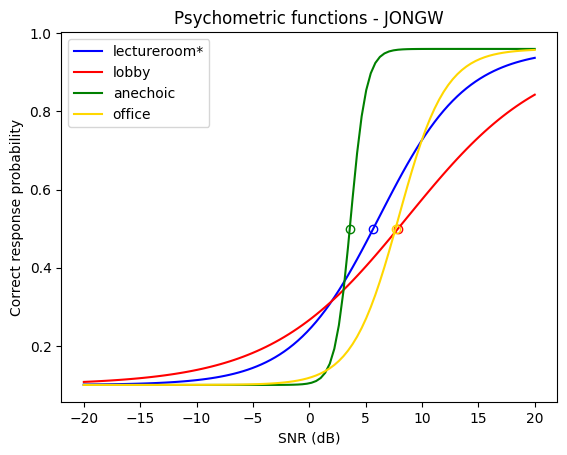

In [24]:
listpatient=[]
for fold in os.listdir(foldpath):
    if patientID in fold:
        listpatient.append(fold)
if len(listpatient)==1:
    foldpath=os.path.join(foldpath, listpatient[0])
    listpatient=[]
    for fold in os.listdir(foldpath):
        if patientID in fold:
            listpatient.append(fold)

colorlist=['b','r','g','gold', 'darkgrey']
colorlistflash=['aqua', 'mistyrose', 'lime', 'yellow', 'lightgrey']
filelist=[]
estimatelist=[]
conditionlist=[]
timinglist=[]
i=0
for condition in listpatient:
    conditionlist.append(condition.split(patientID)[-1])
    for path, subdirs, files in os.walk(os.path.join(foldpath, condition)):
        for name in files:
            if 'pkl' in name:
                if 'paused' in name:
                    print('Warning: patient took a pause in '+ conditionlist[-1])
                    conditionlist[-1]+='*'
                else:
                    timinglist.append(path.split('/')[-1])
                    with open(os.path.join(path,name), 'rb') as f:
                        [estimate, __,__, __, __]=pickle.load(f)
                        estimatelist.append(estimate)
for i in range(len(estimatelist)):
    estimatelist[i].plot('f',0)
    plt.gca().lines[-2].set_color(colorlist[i])
    plt.gca().lines[-1].set_color(colorlist[i])

ax = plt.gca()
plt.title('Psychometric functions - ' + patientID)
handles, labels = ax.get_legend_handles_labels()
reformattime=[timinglist[i][0:4]+'_'+timinglist[i][4:6]+'_'+timinglist[i][6:8]+' '+timinglist[i][9:11]+':'+timinglist[i][11:13]+':'+timinglist[i][13:15] for i in range(len(conditionlist))]
plotlgd=[conditionlist[i]+'  '+reformattime[i] for i in range(len(conditionlist))]
(ax.legend(handles, conditionlist));
for i in range(len(plotlgd)):
    print(plotlgd[i])
# plt.savefig('thoanfunc.pdf', bbox_inches='tight')

## Probability plots
This plots the **joint posterior probability density function** of the SRT and slope parameters. It gives the probability that the true parameters take a certain value given the measurements we have made - brighter colors indicate a higher probability.

The x-axis gives the SRT values and the y-axis gives the slope values.

A more densely concentrated plot can be seen as more 'confident' in the final estimates.

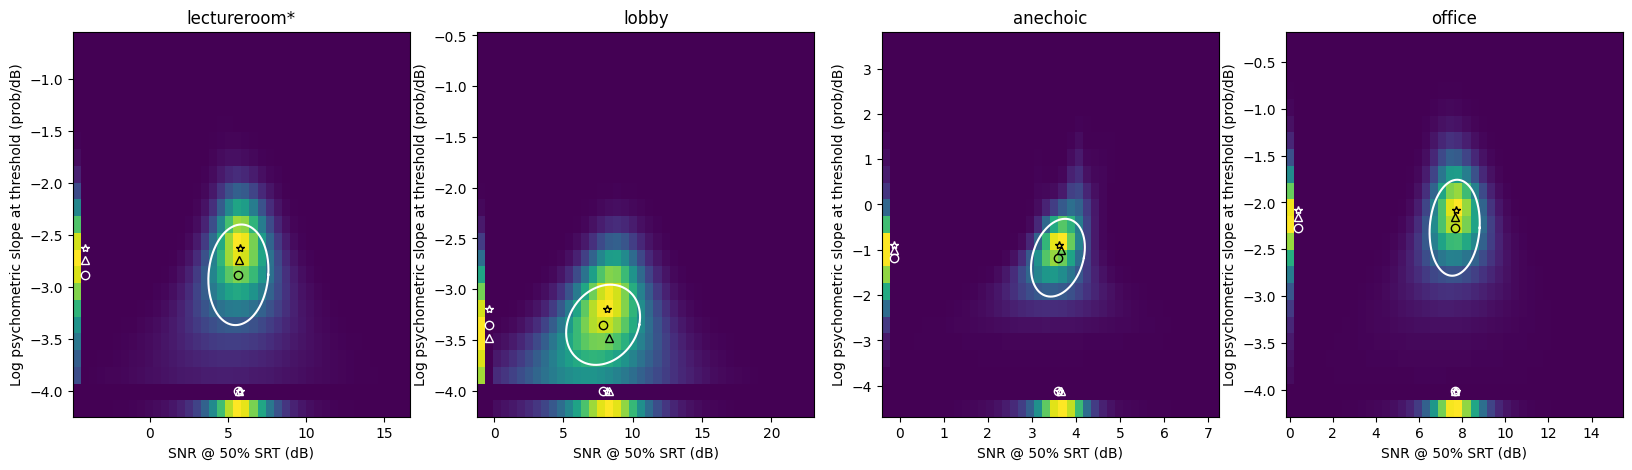

In [25]:
fig, axs=plt.subplots(nrows=1, ncols=len(conditionlist), figsize=(5*len(conditionlist),5))
for i in range(len(conditionlist)):
    plt.sca(axs[i])
    estimatelist[i].plot('p',0)
    plt.title(conditionlist[i])
#     axs[i].set_xlim([-3,15])
plt.savefig('blaadprob.pdf', bbox_inches='tight')

## Psychometric curve history
This plots the evolution of the psychometric curve estimation over the 40 samples. Lighter lines correspond to early samples while darker lines show recent estimates. This is a simple visualisation which gives less information than the probability plot above - it might still give an idea of the variance in the estimate. 

/Users/emiliedolne/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/Year 3/Smartter hear/py_bayesi/utils/basie_class.py:972: RuntimeWarning: overflow encountered in exp
  prt = guess + pscale*((1 + np.exp(np.tile((np.outer(sqis, xqi) - xtstd).ravel(order="F"),(int(nxhp),1))-
/Users/emiliedolne/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/Year 3/Smartter hear/py_bayesi/utils/basie_class.py:641: RuntimeWarning: overflow encountered in exp
  wq2 = wq2 + np.log(r0 + (1 - 2*r0) * (guess + pscale * (1 + np.exp(np.multiply(sqis, xq2.T) - xtstd - np.multiply(sqis, res[j,1])))**(-1))) # P(l | r,x)
/Users/emiliedolne/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/Year 3/Smartter hear/py_bayesi/utils/basie_class.py:738: RuntimeWarning: overflow encountered in exp
  (((1 + np.exp((np.outer(sqis, xqi) - xtstd)-np.tile((x*sqis),(int(nxq),1)).T)).ravel(order='F'))**(-1)))) # P(l | r,x)
/Users/emiliedolne/Library/CloudStorage/OneDrive-ImperialCollegeLondon/PhD/Year 3/Smartte

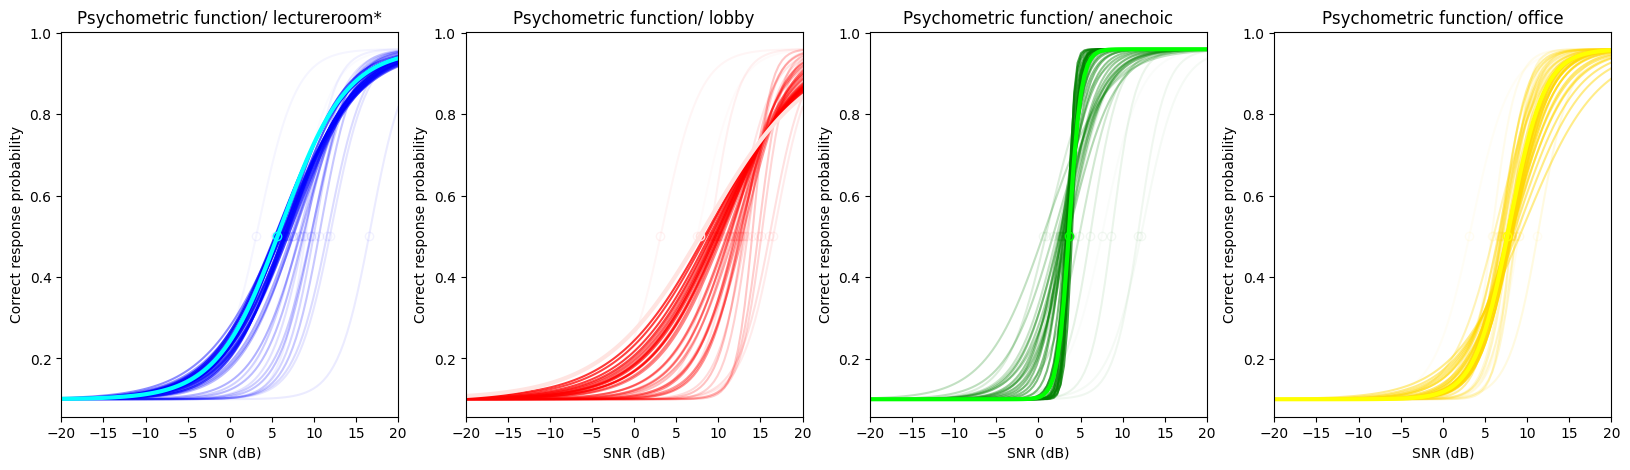

In [26]:
# estimatelist[0].summary()[2][0][2]
fig, axs=plt.subplots(nrows=1, ncols=len(conditionlist), figsize=(5*len(conditionlist),5))

for j in range(len(conditionlist)):
    plt.sca(axs[j])
    patient1estimate=basie_estimator()
    patient1estimate.initialise(1, modelp=estimatelist[j].summary()[0], availsnr=np.linspace(-20, 20, 41).T,
                               basiep=estimatelist[j].summary()[1])
    for i in range(len(estimatelist[j].summary()[2])):
        response = estimatelist[j].summary()[2][i][2];
        snr=estimatelist[j].summary()[2][i][1]

        [__, __, m, v] =patient1estimate.update(0, probesnr=snr, response=response, robust=False)
        patient1estimate.plot('f', 0)
        if i>0:
            plt.gca().lines[2*i-2].set_alpha(i/(40+10))
            plt.gca().lines[2*i-2].set_color(colorlist[j])
            plt.gca().lines[2*i-1].set_alpha(0.05)
            plt.gca().lines[2*i-1].set_color(colorlist[j])
    plt.gca().lines[-1].set_color(colorlistflash[j])
    plt.gca().lines[-2].set_color(colorlistflash[j])
    plt.gca().lines[-1].set_linewidth(3)
    plt.gca().lines[-2].set_linewidth(3)
    axs[j].set_xlim([-20, 20])
    plt.title(axs[j].get_title()+ '/ ' +conditionlist[j])

# Trial history plot
These plots jointly show the response and estimation history.
- The red **+**s and blue **o**s indicate a correct/incorrect response at a given trial number and the corresponding input SNR.
- The full blue line shows the SRT estimate as a function of trial number
- The upper/lower dotted blue lines show the estimated 25%/75% intelligibilty points obtained using the slope estimate

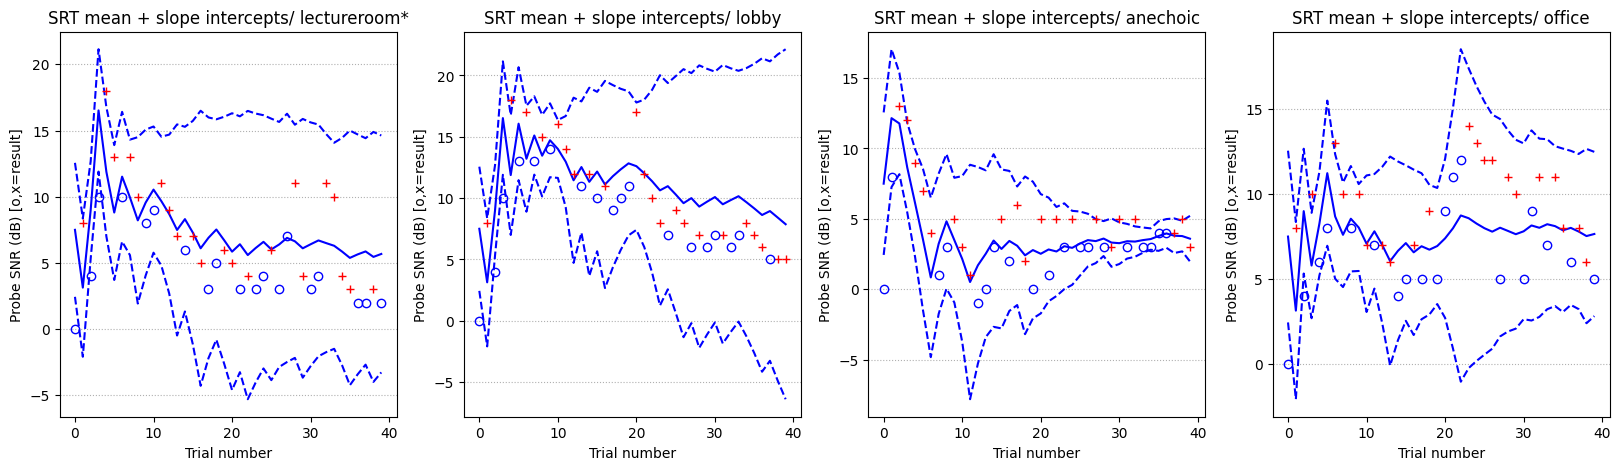

In [27]:
fig, axs=plt.subplots(nrows=1, ncols=len(conditionlist), figsize=(5*len(conditionlist),5))

for i in range(len(conditionlist)):
    plt.sca(axs[i])
    estimatelist[i].plot('h',0)
    plt.title(axs[i].get_title()+ '/ ' +conditionlist[i])

# Cost function evolution
This gives an idea of whether the algorithm has converged to a solution. The red line shows the convergence for SRT only, and the blue curve shows convergence for SRT and slope jointly.

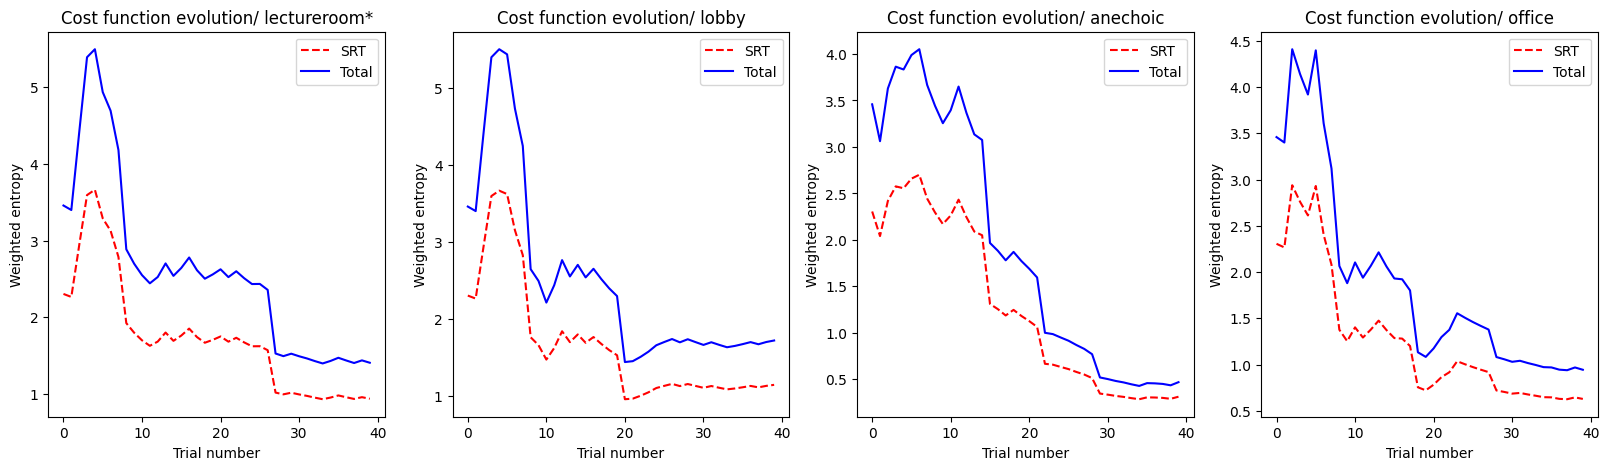

In [28]:
fig, axs=plt.subplots(nrows=1, ncols=len(conditionlist), figsize=(5*len(conditionlist),5))

for i in range(len(conditionlist)):
    plt.sca(axs[i])
    estimatelist[i].plot('c',0)
    plt.title(axs[i].get_title()+ '/ ' +conditionlist[i])